In [41]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

# Useful Functions

In [42]:
np.random.seed(100)

In [43]:
def draw_graph(G, colour_map, pos=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    if pos is None:
        nx.draw(G, node_color=colour_map, ax=ax, node_size=200)
    else:
        nx.draw(G, pos, node_color=colour_map, ax=ax, node_size=200)

In [44]:
# Method for initializing the weights of neural networks. It generates it with the bounds (-std, std) on a matrix of size (n_in, n_out). 
# Stops gradient exploding/vanishing issues. Not random on a sigmoid function because the meaning of the values that are too big/small lose meaning
def xavier(n_in, n_out):
    std = np.sqrt(6.0 / (n_in + n_out))
    return np.random.uniform(-std, std, size=(n_in, n_out))


# Cross Entropy Loss for Classification Problem
def loss_calc(pred, labels):
    true_labels = np.argmax(labels, axis=1)
    log_neg = -np.log(pred)
    return log_neg[np.arange(pred.shape[0]), true_labels]

# DataSet - Zachary's Karate Club


In [45]:
G = nx.karate_club_graph()

In [46]:
nx.is_weighted(G)

True

In [47]:
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
n_nodes, n_edges

(34, 78)

In [48]:
node_attri = nx.get_node_attributes(G,'club')

In [49]:
# communities = greedy_modularity_communities(G)

In [50]:
colouring = pd.get_dummies(node_attri, drop_first=True).astype(float).to_numpy().flatten()

In [51]:
# colouring = np.zeros(n_nodes)
# for idx, community in enumerate(communities):
#     colouring[list(community)] = idx

n_labels = 2
labels = np.eye(n_labels)[colouring.astype(int)]

In [52]:
print(colouring)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


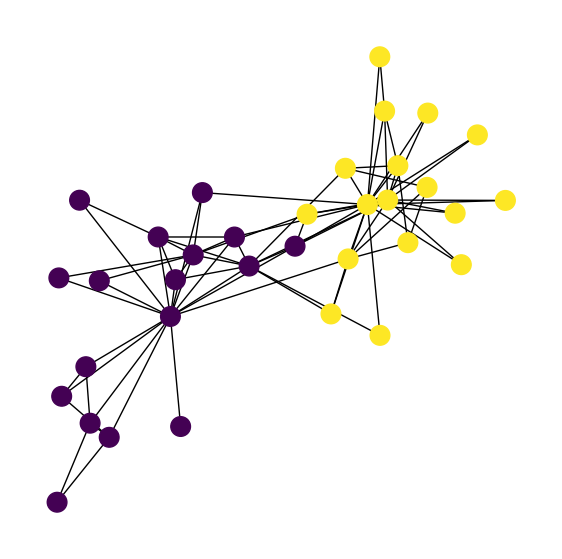

In [53]:
draw_graph(G, colouring)

# Adjacency Matrix

In [54]:
A = nx.to_numpy_array(G)

In [55]:
# Following https://arxiv.org/pdf/1609.02907.pdf
# Adding self connections
A_mod = A + np.eye(n_nodes)

D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, np.asarray(A_mod.sum(axis=1)).flatten())

D_mod_invroot = np.linalg.inv(np.sqrt(D_mod))
A_hat = D_mod_invroot @ A_mod @ D_mod_invroot

In [56]:
#Input features, Since we dont have any node features, just start with an identity matrix
X = np.eye(n_nodes)


# Optimiser

In [57]:
class Optimiser:
    def __init__(self, learning_rate, weight_decay):
        self.lr = learning_rate
        self.wd = weight_decay
        self.out = None
        self.y_pred = None
        self.y_true = None
        self.out = None
        self.train_nodes = None
        self.n_inputs = None

    def update(self, train_nodes=None):
        if train_nodes is None:
            self.train_nodes = np.arange(y_pred.shape[0])
        else:
            self.train_nodes = train_nodes
        self.n_inputs = self.train_nodes.shape[0]


# Graph Convolution Network Layer

In [58]:
class GCNLayer:
    def __init__(self, n_inputs, n_outputs, activation, name):
        #Number of input/output features
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        # Initialising weights 
        self.weights = xavier(self.n_outputs, self.n_inputs)
        # Activation function if needed, probably not gonna use it but ok
        self.act_func = activation
        # Convenient display
        self.name = name
        #Used Later
        # Normalised Adjacency Matrix A
        self.adjacency_m = None
        # Matrix to represent th message passing stage A @ X
        self.message_passing_m = None
        # H 
        self.layer_output_m = None

    #Forward propagation and message sharing among nodes
    def forward(self, A, previous_layer_output, W=None):
        self.adjacency_m = A  # (n, n) 
        self.message_passing_m = (self.adjacency_m @ previous_layer_output).T

        if W is None:
            W = self.weights

        self.layer_output_m = W @ self.message_passing_m
        self.layer_output_m = self.act_func(self.layer_output_m)
        return self.layer_output_m.T

    # Backwards propagation, correcting for loss.
    def backward(self, optimiser: Optimiser):
        d_tanh = 1 - np.asarray(self.layer_output_m.T) ** 2
        d2 = np.multiply(d_tanh, optimiser.out)

        gradient = self.adjacency_m @ d2 @ self.weights
        optimiser.out = gradient

        #Same as SoftMax Layer without bias
        dW = (d2.T @ self.message_passing_m.T) / optimiser.n_inputs
        dW_wd = self.weights * optimiser.wd / optimiser.n_inputs

        #Updating W
        self.weights -= (dW + dW_wd) * optimiser.lr

        return dW + dW_wd



# SoftMax Layer

In [59]:
class SoftmaxLayer:
    def __init__(self, n_inputs, n_outputs, name):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = xavier(self.n_outputs, self.n_inputs)
        self.bias = np.zeros(shape=(self.n_outputs, 1))
        self.name = name
        self.input_feature_m = None  # Used to calculate gradients

    def softmax(self, input):
        s = np.max(input, axis=1)
        s = s[:, np.newaxis]  # necessary step to do broadcasting
        e_x = np.exp(input - s)
        div = np.sum(e_x, axis=1)
        div = div[:, np.newaxis]
        return e_x / div

    def forward(self, input_feature_m, W=None, bias=None):
        self.input_feature_m = input_feature_m.T
        if W is None:
            W = self.W
        if bias is None:
            bias = self.bias

        final_layer_out = np.asarray(W @ self.input_feature_m) + bias
        return self.softmax(final_layer_out.T)

    def backward(self, optimiser: Optimiser):
        # Build mask on loss, only use the nodes in training
        train_mask = np.zeros(optimiser.y_pred.shape[0])
        train_mask[optimiser.train_nodes] = 1
        train_mask = train_mask.reshape((-1, 1))

        # derivative of loss w.r.t. activation (pre-softmax)
        d1 = np.asarray((optimiser.y_pred - optimiser.y_true))
        d1 = np.multiply(d1, train_mask)

        #Create gradient by multiplying difference with weights
        gradient = d1 @ self.W
        optimiser.out = gradient

        #Calculate change in W matrix and b for the softmax layer
        #Change in learnable weights
        dW = (d1.T @ self.input_feature_m.T) / optimiser.n_inputs
        #Change in bias
        db = d1.T.sum(axis=1, keepdims=True) / optimiser.n_inputs
        #Change due to weight decay, L2 Regularization
        dW_wd = self.W * optimiser.wd / optimiser.n_inputs

        # Updating Weights and biases * learning rate
        self.W -= (dW + dW_wd) * optimiser.lr
        self.bias -= db.reshape(self.bias.shape) * optimiser.lr

        return dW + dW_wd, db.reshape(self.bias.shape)


# Graph Convolution Network

In [60]:
class GCNNetwork:
    def __init__(self, n_inputs, n_outputs, hidden_sizes, activation):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = len(hidden_sizes)
        self.hidden_sizes = hidden_sizes
        self.activation = activation

        self.layers = []
        # Input layer
        # GCNLayer(n_inputs, n_outputs, activation, name)
        gcn_in = GCNLayer(n_inputs, hidden_sizes[0], activation, name='in')
        self.layers.append(gcn_in)

        # Hidden layers
        for layer in range(self.n_layers):
            if layer == 0:
                gcn = GCNLayer(hidden_sizes[layer], hidden_sizes[layer], activation, name=f'h{layer}')
            else:
                gcn = GCNLayer(hidden_sizes[layer - 1], hidden_sizes[layer], activation, name=f'h{layer}')
            self.layers.append(gcn)

        # Output layer
        sm_out = SoftmaxLayer(hidden_sizes[-1], n_outputs, name='sm')
        self.output_layer = sm_out

    def embedding(self, A, X):
        # Loop through all GCN layers
        H = X
        for layer in self.layers:
            H = layer.forward(A, H)
        return np.asarray(H)

    def forward(self, A, X):
        # GCN layers
        H = self.embedding(A, X)
        # Softmax
        p = self.output_layer.forward(H)
        return H, np.asarray(p)

# Training

In [75]:
gcn_model = GCNNetwork(
    n_inputs=n_nodes,
    n_outputs=n_labels,
    hidden_sizes=[16, 2],
    activation=np.tanh,
)

In [76]:
np.random.seed(100)
# train_nodes = np.random.randint(n_nodes, size=10)
train_nodes = np.array([0, 1, 32, 33])
test_nodes = np.array([i for i in range(labels.shape[0]) if i not in train_nodes])
#Optimiser(learning_rate, weight_decay)
opt = Optimiser(2e-2, 2.5e-2)

In [77]:
embeddings = []
accuracy = []
train_losses = []
test_losses = []

n_iters = 20000
loss_min = 1e6
es_iters = 0
es_steps = 50

for iter in range(n_iters):

    #Forward Propagation
    embedding, y_pred = gcn_model.forward(A_hat, X)
    embeddings.append(embedding)

    opt.y_pred = y_pred
    opt.y_true = labels
    opt.update(train_nodes)

    #Back Propagation
    gcn_model.output_layer.backward(opt)
    for layer in reversed(gcn_model.layers):
        layer.backward(opt)

    # Accuracy for non-training nodes
    predicted_label = np.argmax(y_pred, axis=1)
    actual_label = np.argmax(labels, axis=1)
    acc = (predicted_label == actual_label)[test_nodes]
    accuracy.append(acc.mean())

    #Cross-Entropy Loss Calculation
    loss = loss_calc(y_pred, labels)
    loss_train = loss[train_nodes].mean()
    loss_test = loss[test_nodes].mean()

    train_losses.append(loss_train)
    test_losses.append(loss_test)

    #Checking to see if the model has gone a significant
    #number of iterations without improving
    if loss_test < loss_min:
        loss_min = loss_test
        es_iters = 0
    else:
        es_iters += 1

    if es_iters > es_steps:
        print("Early stopping!")
        break

    if iter % 100 == 0:
        print(f"iter: {iter + 1}, Train Loss: {loss_train:.3f}, Test Loss: {loss_test:.3f}")

train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

iter: 1, Train Loss: 0.703, Test Loss: 0.702
iter: 101, Train Loss: 0.599, Test Loss: 0.651
iter: 201, Train Loss: 0.412, Test Loss: 0.547
iter: 301, Train Loss: 0.199, Test Loss: 0.387
iter: 401, Train Loss: 0.104, Test Loss: 0.280
iter: 501, Train Loss: 0.066, Test Loss: 0.224
iter: 601, Train Loss: 0.048, Test Loss: 0.192
iter: 701, Train Loss: 0.038, Test Loss: 0.172
iter: 801, Train Loss: 0.032, Test Loss: 0.159
iter: 901, Train Loss: 0.028, Test Loss: 0.149
iter: 1001, Train Loss: 0.025, Test Loss: 0.142
iter: 1101, Train Loss: 0.023, Test Loss: 0.136
iter: 1201, Train Loss: 0.021, Test Loss: 0.132
iter: 1301, Train Loss: 0.019, Test Loss: 0.129
iter: 1401, Train Loss: 0.018, Test Loss: 0.126
iter: 1501, Train Loss: 0.018, Test Loss: 0.124
iter: 1601, Train Loss: 0.017, Test Loss: 0.123
iter: 1701, Train Loss: 0.016, Test Loss: 0.121
iter: 1801, Train Loss: 0.016, Test Loss: 0.120
iter: 1901, Train Loss: 0.015, Test Loss: 0.119
iter: 2001, Train Loss: 0.015, Test Loss: 0.119
iter

# Results

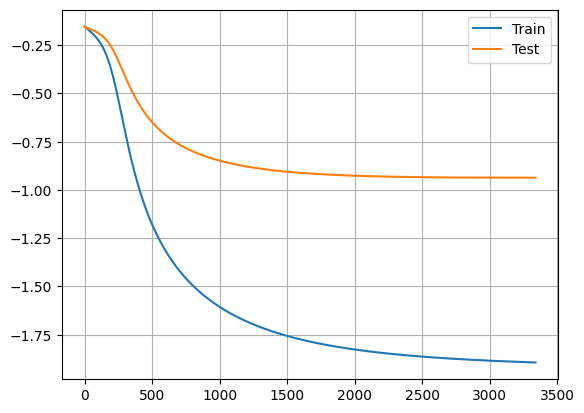

In [78]:
fig, ax = plt.subplots()
ax.plot(np.log10(train_losses), label='Train')
ax.plot(np.log10(test_losses), label='Test')
ax.legend()
ax.grid()

In [79]:
accuracy[-1]

0.9666666666666667

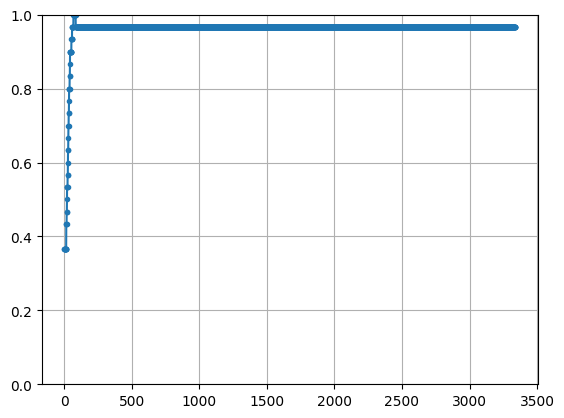

In [80]:
fig, ax = plt.subplots()
_ = ax.plot(accuracy, marker='.')
ax.grid()
_ = ax.set(ylim=[0, 1])

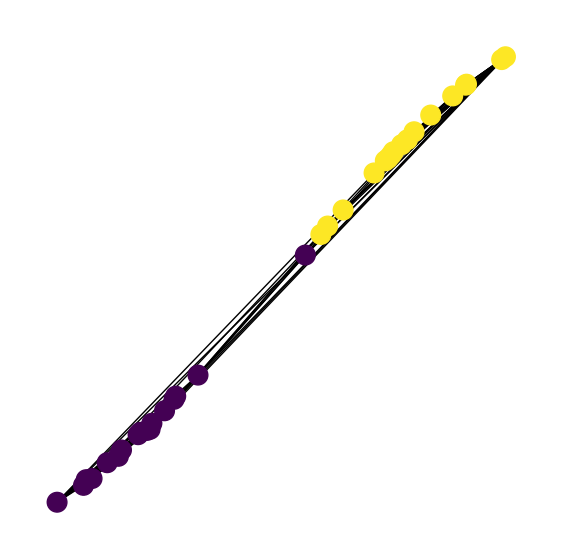

In [81]:
pos = {i: embeddings[-1][i, :] for i in range(embeddings[-1].shape[0])}
draw_graph(G, colouring, pos)